<a href="https://colab.research.google.com/github/Ankit035/Hybrid-LLM-for-Temporal-dataset/blob/main/Hybrid_Model_jena.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip


--2025-05-02 10:01:08--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.207, 74.125.26.207, 172.217.204.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.1s    

2025-05-02 10:01:08 (106 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [ ]:
import pandas as pd
import numpy as np

# Load data with correct date parsing
df = pd.read_csv(
    "jena_climate_2009_2016.csv",
    parse_dates=['Date Time'],
    dayfirst=True
)

# Set Date Time as index
df.set_index('Date Time', inplace=True)

# Inspect data to confirm parsing
print(df.head())
print(df.index.dtype)


                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00      

In [ ]:
import pandas as pd
import numpy as np

# Load data with correct date parsing
df = pd.read_csv(
    "jena_climate_2009_2016.csv",
    parse_dates=['Date Time'],
    dayfirst=True
)

# Set Date Time as index
df.set_index('Date Time', inplace=True)

# Resample to daily means
daily_df = df.resample('D').mean()

# Choose a target variable: e.g., temperature ("T (degC)")
target_col = 'T (degC)'
daily_df = daily_df[[target_col]]
daily_df.rename(columns={target_col: 'temperature'}, inplace=True)

# Initialize feature frame
features = pd.DataFrame(index=daily_df.index)
features['temperature'] = daily_df['temperature']

# Date-based features
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Lag features
features['lag_7'] = features['temperature'].shift(7)
features['lag_30'] = features['temperature'].shift(30)

# Rolling features
features['rolling_7_mean'] = features['temperature'].rolling(7).mean()
features['rolling_30_std'] = features['temperature'].rolling(30).std()

# Fourier features for yearly seasonality
days = np.arange(len(features))
features['sin_annual'] = np.sin(2 * np.pi * days / 365)
features['cos_annual'] = np.cos(2 * np.pi * days / 365)

# Final cleanup
features.dropna(inplace=True)

# Preview final features
print(features.head())


            temperature  day_of_week  month  is_weekend     lag_7    lag_30  \
Date Time                                                                     
2009-01-31    -2.001667            5      1           1  2.580347 -6.810629   
2009-02-01    -3.360486            6      2           1  0.984722 -3.728194   
2009-02-02    -0.729722            0      2           0 -3.284722 -5.271736   
2009-02-03    -0.043681            1      2           0 -1.344236 -1.375208   
2009-02-04    -1.016528            2      2           0 -2.493819 -4.867153   

            rolling_7_mean  rolling_30_std  sin_annual  cos_annual  
Date Time                                                           
2009-01-31       -1.843829        5.082521    0.493776    0.869589  
2009-02-01       -2.464573        5.082448    0.508671    0.860961  
2009-02-02       -2.099573        5.095760    0.523416    0.852078  
2009-02-03       -1.913780        5.119366    0.538005    0.842942  
2009-02-04       -1.702738      

In [ ]:
print(features.columns)


Index(['temperature', 'day_of_week', 'month', 'is_weekend', 'lag_7', 'lag_30',
       'rolling_7_mean', 'rolling_30_std', 'sin_annual', 'cos_annual'],
      dtype='object')


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
import numpy as np

# Load BERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Define embedding extraction function using temperature features
def extract_embedding(row):
    # Create a string from numerical features (temperature-focused)
    text = (
        f"Day {int(row.day_of_week)}, "
        f"Month {int(row.month)}, "
        f"Weekend {int(row.is_weekend)}, "
        f"Temp {row.temperature:.2f}, "
        f"Lag7 {row.lag_7:.2f}, Lag30 {row.lag_30:.2f}, "
        f"RollMean7 {row.rolling_7_mean:.2f}, RollStd30 {row.rolling_30_std:.2f}, "
        f"SinAnnual {row.sin_annual:.2f}, CosAnnual {row.cos_annual:.2f}"
    )
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Compute embeddings
embeddings = np.array([
    extract_embedding(row) for _, row in tqdm(features.iterrows(), total=len(features))
])

# Apply PCA to reduce embedding dimensionality
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(embeddings)

# Append reduced components to features DataFrame
for i in range(embeddings_pca.shape[1]):
    features[f'llm_embed_{i}'] = embeddings_pca[:, i]


100%|██████████| 2861/2861 [14:17<00:00,  3.33it/s]


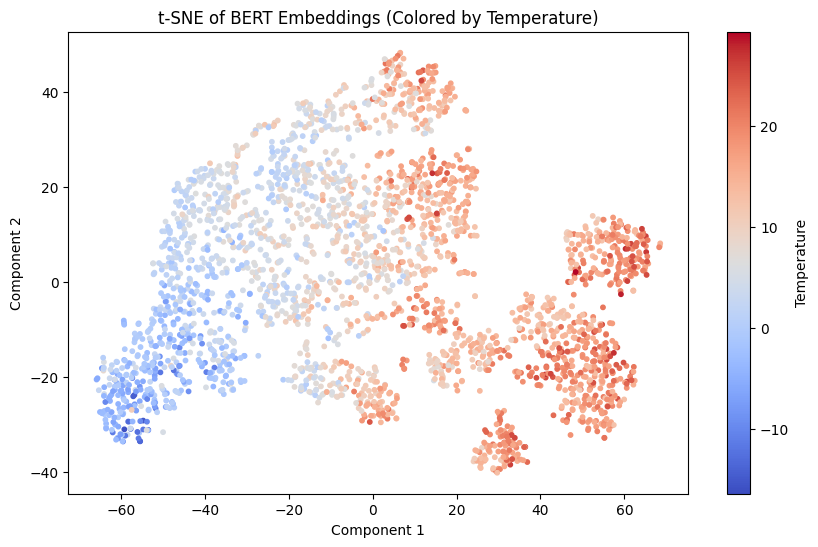

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Reduce LLM embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features[[f"llm_embed_{i}" for i in range(10)]])

# Plot with color based on temperature
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=features['temperature'], cmap='coolwarm', s=10)
plt.colorbar(label="Temperature")
plt.title("t-SNE of BERT Embeddings (Colored by Temperature)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_idx, test_idx in tscv.split(features):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold RMSE: {rmse:.2f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2566
[LightGBM] [Info] Number of data points in the train set: 476, number of used features: 19
[LightGBM] [Info] Start training from score 8.765007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("jena_climate_2009_2016.csv", parse_dates=['Date Time'], dayfirst=True)
df.set_index('Date Time', inplace=True)

# Select relevant features (temperature + others)
columns = [
    'T (degC)',        # Temperature
    'p (mbar)',        # Pressure
    'rh (%)',          # Relative Humidity
    'wv (m/s)',        # Wind Speed
    'max. wv (m/s)',   # Max Wind Speed
    'wd (deg)'         # Wind Direction
]
df = df[columns]

# Resample to daily mean
daily_df = df.resample('D').mean()


#Feature Engineering (Lags, Rolling Stats, Fourier Terms)

In [ ]:
features = daily_df.copy()

# Add date-based features
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Add lag features
for lag in [1, 7, 14]:
    for col in daily_df.columns:
        features[f'{col}_lag_{lag}'] = daily_df[col].shift(lag)

# Add rolling features
for window in [7, 14]:
    for col in daily_df.columns:
        features[f'{col}_roll_mean_{window}'] = daily_df[col].rolling(window).mean()

# Fourier (seasonality)
import numpy as np
days = np.arange(len(features))
features['sin_annual'] = np.sin(2 * np.pi * days / 365)
features['cos_annual'] = np.cos(2 * np.pi * days / 365)

features.dropna(inplace=True)


# Target and Train/Test Split

In [ ]:
# Target: temperature
target = 'T (degC)'
X = features.drop(columns=[target])
y = features[target]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


 # Train LightGBM Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Multivariate RMSE: {rmse:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9455
[LightGBM] [Info] Number of data points in the train set: 2314, number of used features: 40
[LightGBM] [Info] Start training from score 9.067473
Multivariate RMSE: 1.90


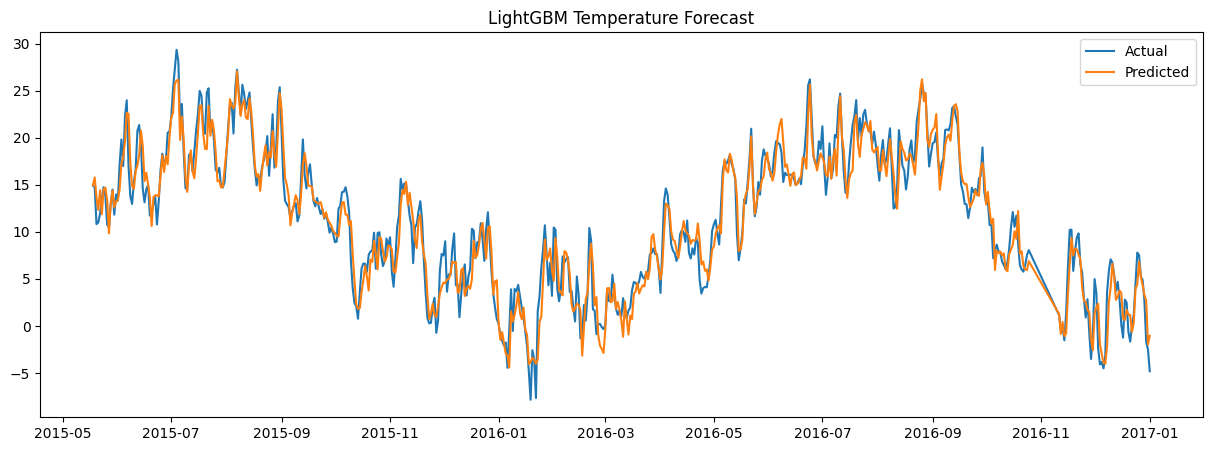

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("LightGBM Temperature Forecast")
plt.legend()
plt.show()


#Turn Weather Data into Natural Language Sentences

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

# Load BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Convert rows into text strings
def row_to_text(row):
    return (
        f"On day {int(row.day_of_week)} of month {int(row.month)}, "
        f"temperature was {row['T (degC)']:.2f}C, humidity {row['rh (%)']:.1f}%, "
        f"pressure {row['p (mbar)']:.1f} mbar, wind speed {row['wv (m/s)']:.2f} m/s."
    )

# Apply BERT to get embeddings
def extract_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

texts = features.apply(row_to_text, axis=1)
embeddings = np.array([extract_embedding(t) for t in tqdm(texts)])


100%|██████████| 2893/2893 [10:04<00:00,  4.78it/s]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
embeddings_pca = pca.fit_transform(embeddings)

# Add to features
for i in range(embeddings_pca.shape[1]):
    features[f'llm_embed_{i}'] = embeddings_pca[:, i]


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Use the same target
X = features.drop(columns=['T (degC)'])
y = features['T (degC)']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# LightGBM
model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print results
print(f"Hybrid Model RMSE: {rmse:.2f}")
print(f"Hybrid Model MAE: {mae:.2f}")
print(f"Hybrid Model R² Score: {r2:.2f}")
print(f"Hybrid Model MAPE: {mape:.2f}%")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12005
[LightGBM] [Info] Number of data points in the train set: 2314, number of used features: 50
[LightGBM] [Info] Start training from score 9.067473
Hybrid Model RMSE: 1.70
Hybrid Model MAE: 1.31
Hybrid Model R² Score: 0.95
Hybrid Model MAPE: 54.99%


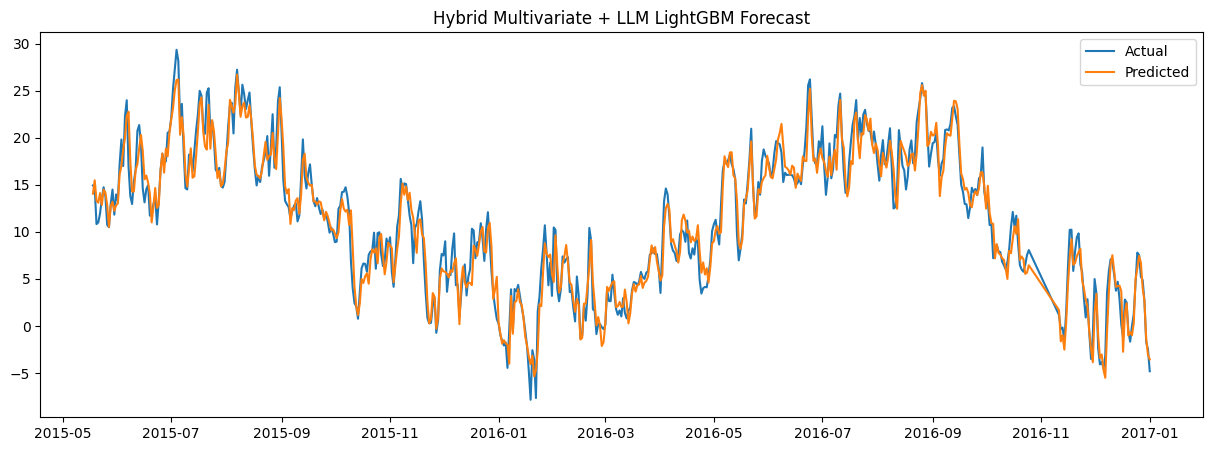

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Hybrid Multivariate + LLM LightGBM Forecast")
plt.legend()
plt.show()


# LightGBM model with an LSTM

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load and prepare base features
features = daily_df.copy()

# Temporal features
features['day_of_week'] = features.index.dayofweek
features['month'] = features.index.month
features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)

# Lag features (1, 7, 14 days)
for lag in [1, 7, 14]:
    for col in daily_df.columns:
        features[f'{col}_lag_{lag}'] = daily_df[col].shift(lag)

# Rolling statistics (7/14 day windows)
for window in [7, 14]:
    for col in daily_df.columns:
        features[f'{col}_roll_mean_{window}'] = daily_df[col].rolling(window).mean()

features.dropna(inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

X = features.drop(columns=['T (degC)'])
y = features['T (degC)']

# Chronological split (no shuffling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    random_state=42
)
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8947
[LightGBM] [Info] Number of data points in the train set: 2314, number of used features: 38
[LightGBM] [Info] Start training from score 9.067473


In [ ]:
# Scale data for LSTM
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

def create_sequences(data, targets, n_steps=14):
    """Generate sequences with perfect alignment"""
    X_seq, y_seq = [], []
    for i in range(n_steps, len(data)):
        X_seq.append(data[i-n_steps:i])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)

# Regenerate with strict alignment
X_seq, y_seq = create_sequences(X_scaled, y.values)
print(f"Corrected sequences: {len(X_seq)}")  # Should now match 2314-14=2300

# Split sequences chronologically
train_size = int(0.8 * len(X_seq))
X_train_lstm, X_test_lstm = X_seq[:train_size], X_seq[train_size:]
y_train_lstm, y_test_lstm = y_seq[:train_size], y_seq[train_size:]

Corrected sequences: 2879


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

# LSTM Branch
lstm_input = Input(shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]))
x = LSTM(64, return_sequences=True)(lstm_input)
x = LSTM(32)(x)
lstm_output = Dense(1, name='lstm_output')(x)

# LightGBM Features Branch
features_input = Input(shape=(X_train.shape[1],))
dense = Dense(16, activation='relu')(features_input)

# Combined Model
combined = Concatenate()([lstm_output, dense])
final_output = Dense(1)(combined)

hybrid_model = Model(
    inputs=[lstm_input, features_input],
    outputs=final_output
)
hybrid_model.compile(optimizer='adam', loss='mse')

In [ ]:
print(f"Original X_train shape: {X_train.shape}")  # Should show (2314, 38)
print(f"Original y_train shape: {y_train.shape}")  # Should match X_train

Original X_train shape: (2314, 38)
Original y_train shape: (2314,)


In [ ]:
# 1. Verify sequence generation
def create_sequences(data, targets, n_steps=14):
    X_seq, y_seq = [], []
    for i in range(n_steps, len(data)):
        X_seq.append(data[i-n_steps:i])
        y_seq.append(targets[i])
    return np.array(X_seq), np.array(y_seq)

# 2. Regenerate sequences with correct alignment
X_seq, y_seq = create_sequences(X_scaled, y.values)
print(f"Total possible sequences: {len(X_seq)}")  # Should be 2300

# 3. Re-split the data
train_size = int(0.8 * len(X_seq))  # 1840 sequences
X_train_lstm, X_test_lstm = X_seq[:train_size], X_seq[train_size:]
y_train_lstm, y_test_lstm = y_seq[:train_size], y_seq[train_size:]

# 4. Align LightGBM features (critical step!)
start_idx = 14  # Skip first 14 (lookback window)
end_idx = start_idx + len(X_seq)  # 14 + 2300 = 2314

X_train_features = X_train.iloc[start_idx:end_idx]
X_test_features = X_test.iloc[start_idx:start_idx+len(X_test_lstm)]

# 5. Verify shapes
print(f"LSTM Train: {X_train_lstm.shape}")  # (1840, 14, 38)
print(f"Features Train: {X_train_features.shape}")  # (1840, 38)
print(f"Target Train: {y_train_lstm.shape}")  # (1840,)

# 6. Train with perfect alignment
history = hybrid_model.fit(
    x=[X_train_lstm, X_train_features],
    y=y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(
        [X_test_lstm, X_test_features],
        y_test_lstm
    )
)

Total possible sequences: 2879
LSTM Train: (2303, 14, 38)
Features Train: (2300, 38)
Target Train: (2303,)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 2303, 2300
'y' sizes: 2303
